In [246]:
## Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlite3    
import pickle     
import time       

import re  

import nltk 
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle, resample


from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import joblib
import pickle

In [244]:
!pip install joblib

In [3]:
review_data = pd.read_csv("/Users/heet/Desktop/Projects/Amazon_food_review_analysis/archive/Reviews.csv")

In [4]:
review_filtered_data = review_data[review_data['Score'] != 3]

In [5]:
# using the SQLite Table to read data.
conn = sqlite3.connect('/Users/heet/Desktop/Projects/Amazon_food_review_analysis/archive/database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", conn)

# close the connection to the database
conn.close()

In [6]:
# View the top 5 rows
review_filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Mark all the reviews with score 1 and 2 as negative while those with score 4 and 5 as positive. Ignore the reviews with score 3.

In [7]:
# Give reviews with Score > 3 a positive rating, and reviews with a Score < 3 a negative rating.
def partition(x):
    if x < 3:
        return 0 # indicating negative
    return 1 # indicating positive

## Pandas Series have a map function which apply function object to all the elements
review_filtered_data['Score'] = list(map(partition,list(review_filtered_data['Score'])))

/var/folders/_r/s8vczyvd2sg838smpnxck6bh0000gn/T/ipykernel_1190/295929830.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_filtered_data['Score'] = list(map(partition,list(review_filtered_data['Score'])))


In [8]:
review_filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
review_filtered_data['Score'].value_counts()

1    443777
0     82037
Name: Score, dtype: int64

In [10]:
#Finding the null values in the data
review_filtered_data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   25
Text                       0
dtype: int64

#### Since the data have null values only in profile name and summary, we will not remove it because it will not effect data for further analyzing and modelling. To classify sentiments of review the most important feature is text.

## Exploratory Data Analysis and Data Cleaning
### Cleaning Part 1 - Deduplication (Removing duplicates from the data)
Many real world data contain duplicate entries which must be removed otherwise we may get biased results<br>
There are sayings in ML that **Garbage in - Garbage out**, and **Better Data beats Fancier Algorithms**

Let's check for some random user (Note: this was found after doing some experimentations)

In [11]:
review_filtered_data[(review_filtered_data['ProfileName'] == 'R. Ellis "Bobby"') & \
              (review_filtered_data['Summary'] == 'The price is right')]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
8934,8935,B0007A0AP8,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",15,15,1,1303862400,The price is right,We have a little Maltese that we spoil to no e...
175816,175817,B0014DUUFC,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",15,15,1,1303862400,The price is right,We have a little Maltese that we spoil to no e...
534266,534267,B0007A0AOY,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",15,15,1,1303862400,The price is right,We have a little Maltese that we spoil to no e...
545769,545770,B001E5E1C8,A74SHV5ZD3RLT,"R. Ellis ""Bobby""",15,15,1,1303862400,The price is right,We have a little Maltese that we spoil to no e...


**Why these duplicate rows are present in the dataset?**
1. On doing some research and using some domain knowledge it was found that if a user gives a review for a product, then sometimes, that review appears on all the different brands of the same product.
2. Since this data was collected by scraping the HTML pages, we are getting the same review multiple times.
3. For example refer the below pages:<br>
https://www.amazon.com/dp/B0007A0AP8<br>
https://www.amazon.com/dp/B0007A0AOY
4. Getting the same text in train and test will lead to biased results

In [12]:
# Deduplication - If there are multiple rows with same user id and text, keep ony one and remove rest
final=review_filtered_data.drop_duplicates(subset={"UserId", "Text"})
final.shape

(363859, 10)

In [13]:
#Checking the percentage of data left out of original data
percentage_left = (final.shape[0]/review_filtered_data.shape[0])*100
print(percentage_left)

69.19918450250468


**Observe:** We are left with approx 69% of the original data after cleaning which means more than 30% was duplicate data

#### HelpfulnessNumerator must always be less than or equal to HelpfulnessDenominator. Lets check if this always the case

In [14]:
final[final['HelpfulnessNumerator'] > final['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


There is something wrong in these two rows and must be removed

In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(363857, 10)

In [16]:
final['Score'].value_counts()

1    306779
0     57078
Name: Score, dtype: int64

**Note:** Not a very balanced dataset

### Cleaning Part 2 -  We can see that many reviews contain HTML tags and special characters which are unwanted for our purpose

In [17]:
# Print text of rows containing HTML tags
i = 0
for s in final['Text'].values:
    if(len(re.findall('<.*?>', s))): # Find all strings starting with '<' and ending with '>'
        print(s,"\n\n")
        i += 1
    if i == 5:
        break

I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service! 


Twizzlers, Strawberry my childhood favorite candy, made in Lancaster Pennsylvania by Y & S Candies, Inc. one of the oldest confectionery Firms in the United States, now a Subsidiary of the Hershey Company, the Company

### Cleaning Part 3 -  Stopword Removal
**Stopwords are those words which do not provide much meaning to the sentences**

In [18]:
stop_words = set(stopwords.words('english')) #set of stopwords
print(stop_words)

{'weren', 'themselves', 'about', 'then', 'my', 'll', 'its', 'nor', "didn't", "mightn't", 'down', 'any', 'that', 'shan', 'they', 'these', 'be', 'had', "weren't", "shan't", 't', 'into', 'too', 'when', 'won', 'over', 'don', 'just', 'again', 'in', "won't", 'what', "you'll", 'having', 'on', 'your', 'them', 'by', 'a', 'off', 'if', 'he', 'their', 'those', 'there', 'were', "should've", 'ours', 'between', 'hasn', "hadn't", "you're", 'ain', 'until', "that'll", 'do', 'after', "wouldn't", 'wasn', "wasn't", 'his', 'which', 'shouldn', "shouldn't", 'was', 'y', 'out', 'so', 'ourselves', 'i', 'such', 'her', 'should', 'at', 'is', 'herself', "couldn't", 'mustn', "don't", 'been', 'as', 'once', 'both', 'me', 'no', 'isn', 'hers', 'from', 'himself', 'hadn', "haven't", 'who', 'against', 're', 'ma', 'you', 'under', 'few', 'does', 'but', 'through', 'above', 'same', 've', 'of', 'mightn', 'it', 'are', 'other', 'very', "she's", 'not', 'and', 'o', 'him', 'only', "needn't", 'didn', 'our', 'below', "mustn't", 'during

### Cleaning Part 4 - Stemming
**In linguistic morphology and information retrieval, stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form**

In [19]:
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

### Function to perform all the cleaning on the reviews

In [20]:
def data_cleaning(series):
    i = 0
    string = ""
    final_string = []    ## This list will contain cleaned sentences
    list_of_sent = []    ## This is a list of lists used as input to the W2V model at a later stage
    cleanr = re.compile('<.*?>') # Compile re to remove html tags
    
    for sent in series.values:
        filtered_sent = []
        sent = re.sub(cleanr, ' ', sent) # remove html tags
        sent = re.sub('[^a-zA-Z0-9\n]', ' ', sent) # remove special characters
        sent = re.sub('\s+',' ', sent) # replace multiple spaces with single space
        sent = sent.lower() # convert all characters to lower case
        for word in sent.split():
            if word not in stop_words and len(word)>2:
                word = sno.stem(word) # Apply Stemming using snowball stemmer
                filtered_sent.append(word)
        list_of_sent.append(filtered_sent) # This list is used later
        string = " ".join(filtered_sent) # Cleaned sentence
        final_string.append(string) # List of cleaned sentences
        i+=1
    return final_string, list_of_sent

#### First 5 reviwes before cleaning

In [21]:
for x in final['Text'].iloc[:5].values:
    print(x,"\n\n")

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. 


Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo". 


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch. 


If you are looking for the

#### First 5 reviwes after cleaning

In [22]:
final_string, list_of_sent = data_cleaning(final['Text'].iloc[:5])
for x in final_string:
    print(x,"\n\n")

bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better 


product arriv label jumbo salt peanut peanut actual small size unsalt sure error vendor intend repres product jumbo 


confect around centuri light pillowi citrus gelatin nut case filbert cut tini squar liber coat powder sugar tini mouth heaven chewi flavor high recommend yummi treat familiar stori lewi lion witch wardrob treat seduc edmund sell brother sister witch 


look secret ingredi robitussin believ found got addit root beer extract order good made cherri soda flavor medicin 


great taffi great price wide assort yummi taffi deliveri quick taffi lover deal 




#### Cleaning all the reviews

In [23]:
start = time.time()
final_string, list_of_sent = data_cleaning(final['Text'])
end = time.time()
print("Time takes in seconds =", end - start)

Time takes in seconds = 162.3111469745636


In [24]:
# Adding a column of CleanedText which displays the data after cleaning of the reviews
final['CleanedText']=final_string
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


#### Save the updated DataFrame as an SQL Table for future use

In [25]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
final.to_sql('Reviews', conn, if_exists='replace', index = False)
conn.close()

#### Save the list_of_sent in a pickle file so that you can directly load the pickle file every time you use in future

In [26]:
with open('list_of_sent_for_input_to_w2v.pkl', 'wb') as pickle_file:
    pickle.dump(list_of_sent, pickle_file)

### Read the file containing cleaned reviews

In [111]:
conn = sqlite3.connect('/Users/heet/Desktop/Projects/Amazon_food_review_analysis/final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()

In [112]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


#### Since KNN is a bit slow and requires more RAM, we will use a sample of the dataset.
Since we are sampling the dataset, we will create a balanced dataset containing only 10000 points (5000 positive and 5000 negative)

In [121]:
negative = final[final['Score'] == 0][['Score', 'Time', 'CleanedText']]
positive = final[final['Score'] == 1][['Score', 'Time', 'CleanedText']]
data = pd.concat([negative.iloc[:10000,:], positive.iloc[:10000,:]], axis = 0, ignore_index = True)
## Sort the dataframe on time
data.sort_values('Time', inplace = True)
data.head(10)

,Score,Time,CleanedText
10954,1,961718400,realli good idea final product outstand use de...
10953,1,962236800,receiv shipment could hard wait tri product lo...
18782,1,1067990400,chatchi favorit afternoon treat becam mysteri ...
16199,1,1075420800,winter fresh blueberri exceed food budget dri ...
18040,1,1081209600,like strong smooth flavor coffe tri other keep...
12890,1,1081555200,mae ploy sweet chili sauc becom standard condi...
15647,1,1083456000,love snack want buy bunch ship amazon price sn...
4650,0,1084665600,suppos avoid sugar urinari tract infect
18784,1,1087689600,crazi soft spot chuckl know darn well one favo...
10924,1,1088467200,perfect year round meat dish omaha steak twice...


In [30]:
data.shape

(20000, 3)

In [32]:
data['Score'].value_counts()

1    10000
0    10000
Name: Score, dtype: int64

### Separate the featues fom the target variable

In [67]:
X = data['CleanedText']
y = data['Score']

### Train Test Split

In [68]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [69]:
X_train_raw.shape, y_train.shape, X_test_raw.shape, y_test.shape

((14000,), (14000,), (6000,), (6000,))

#### Vectorizing the text using Bag of Words model

In [70]:
# Create an object of class CountVectorizer
bow = CountVectorizer()
# Call the fit_transform method on training data
X_train = bow.fit_transform(X_train_raw.values)

In [71]:
X_train.shape

(14000, 15562)

#### This means the size of the vocaulary in the training set is 11142

In [72]:
# Call the transform method on the test dataset
X_test = bow.transform(X_test_raw.values)

In [73]:
X_test.shape

(6000, 15562)

### Column Standardization

In [74]:
# Create an object of StandardScaler
s = StandardScaler(with_mean=False) # Since we are passing sparse matrix
# Call the fit_transform method on training data
X_train = s.fit_transform(X_train)
# Call the transform method on the test dataset
X_test = s.transform(X_test)

In [75]:
def hyper_param_knn(X_train, y_train, neighbors):
    
    cv_scores = [] # empty list that will hold cv scores

    # Try each value of k in the below loop
    for k in neighbors:
        # Create an object of the class KNeighborsClassifier
        knn = KNeighborsClassifier(n_neighbors=k)
        # perform 5-fold cross validation
        # It returns the cv accuracy for each fold in a list
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        # Store the mean of the accuracies from all the 4 folds
        cv_scores.append(scores.mean())

    # calculate misclassification error from accuracy (error = 1 - accuracy)
    cv_error = [1 - x for x in cv_scores]

    # optimal (best) k is the one for which error is minimum (or accuracy is maximum)
    optimal_k = neighbors[cv_error.index(min(cv_error))]
    

    return optimal_k, cv_error

## Model Building - Hyperparameter tuning and k-fold Cross validation

In [76]:
# creating odd list of K for KNN
neighbors = range(1,20,2)

optimal_k, cv_error = hyper_param_knn(X_train, y_train, neighbors)
print('\nThe optimal number of neighbors is', optimal_k)


The optimal number of neighbors is 9


Text(0, 0.5, 'Misclassification Error')

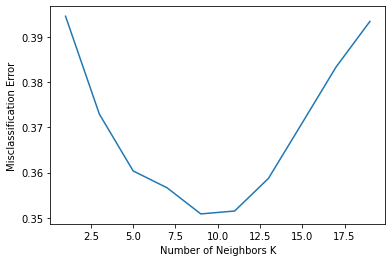

In [77]:
# plot misclassification error vs k 
plt.plot(neighbors, cv_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

### Build the final model with the optimal value of k

In [78]:
clf = KNeighborsClassifier(n_neighbors = optimal_k)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

### Make the predictions on the test set

In [79]:
y_pred = clf.predict(X_test)

### Calculate test accuracy

In [80]:
acc = accuracy_score(y_test, y_pred) * 100
acc

66.91666666666667

### Check the confusion matrix

In [81]:
confusion_matrix(y_test, y_pred)

array([[1785, 1486],
       [ 499, 2230]])

### Predict Probabilities

In [82]:
# Select a random test point
i = np.random.randint(1,3000)
y_pred = clf.predict(X_test[i])[0]
y_proba = clf.predict_proba(X_test[i])[0]
print("Actual class:",y_test.iloc[i])
print("Predicted class class:",y_pred)
print("Predicted probabilities",y_proba)

Actual class: 1
Predicted class class: 1
Predicted probabilities [0.44444444 0.55555556]


#### Vectorizing the text using TFIDF model

In [83]:
# Create an object of class CountVectorizer
tfidf = TfidfVectorizer()
# Call the fit_transform method on training data
X_train = tfidf.fit_transform(X_train_raw.values)

In [84]:
# Call the transform method on the test dataset
X_test = tfidf.transform(X_test_raw.values)

### Column Standardization

In [85]:
s = StandardScaler(with_mean=False)
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

## Model Building - Hyperparameter tuning and k-fold Cross validation

In [86]:
optimal_k, cv_error = hyper_param_knn(X_train, y_train, neighbors)
print('\nThe optimal number of neighbors is', optimal_k)


The optimal number of neighbors is 3


Text(0, 0.5, 'Misclassification Error')

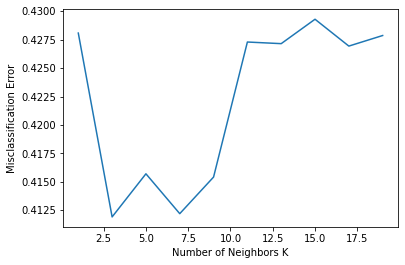

In [87]:
# plot misclassification error vs k 
plt.plot(neighbors, cv_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

### Build the final model with the optimal value of k

In [88]:
clf = KNeighborsClassifier(n_neighbors = optimal_k)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Make the predictions on the test set

In [89]:
y_pred = clf.predict(X_test)

### Calculate test accuracy

In [90]:
acc = accuracy_score(y_test, y_pred) * 100
acc

58.18333333333333

### Check the confusion matrix

In [91]:
confusion_matrix(y_test, y_pred)

array([[1237, 2034],
       [ 475, 2254]])

### Predict Probabilities

In [92]:
# Select a random test point
i = np.random.randint(1,3000)
y_pred = clf.predict(X_test[i])[0]
y_proba = clf.predict_proba(X_test[i])[0]
print("Actual class:",y_test.iloc[i])
print("Predicted class class:",y_pred)
print("Predicted probabilities",y_proba)

Actual class: 1
Predicted class class: 1
Predicted probabilities [0.33333333 0.66666667]


### Read the file containing cleaned reviews

In [93]:
with open('/Users/heet/Desktop/Projects/Amazon_food_review_analysis/list_of_sent_for_input_to_w2v.pkl', 'rb') as pickle_file:
    list_of_sent = pickle.load(pickle_file)

### Recall below is the first element of list_of_sent

In [94]:
print(list_of_sent[0])

['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better']


#### Training the Word2Vec model for words with min count 5¶
Reference for intuition - https://www.tensorflow.org/tutorials/word2vec

In [98]:
## size is the no of dimensions
## min_count specifies the min no of times a word needs to occur to be included in the model
## workers is the number of cores on your PC
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,vector_size = 50, workers=-1)

In [102]:
# Check the number of unique words in the vocabulary
words = w2v_model.mv
print(len(words))

23157


**Intuitive understanding of W2V - Check the most similar words to a given word**

In [103]:
w2v_model.wv.most_similar('tasti')

[('cappucino', 0.5750657320022583),
 ('possibl', 0.5315594673156738),
 ('lucienn', 0.512749195098877),
 ('shape', 0.5101866722106934),
 ('seventh', 0.47897374629974365),
 ('tabasco', 0.47692710161209106),
 ('akhdar', 0.46660658717155457),
 ('usrda', 0.4642166793346405),
 ('grogg', 0.46275606751441956),
 ('enclosur', 0.46057912707328796)]

In [104]:
w2v_model.wv.most_similar('like')

[('unlov', 0.571351945400238),
 ('hobnob', 0.5570385456085205),
 ('deposit', 0.5327945351600647),
 ('fructus', 0.5002596974372864),
 ('katj', 0.4928179383277893),
 ('clich', 0.4907900393009186),
 ('tune', 0.4857129752635956),
 ('ann', 0.48262038826942444),
 ('version', 0.4813557267189026),
 ('slop', 0.47297370433807373)]

## Function to calculate Avg Word2Vec

In [105]:
def calc_avg_w2v(list_of_sent, w2v_model):
    '''This function takes in 2 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       
       Return Value:
       sent_vectors - This is a list of sentence/review vectors constructed by averaging the word vectors
    '''
    
    ## Initialize an empty list
    sent_vectors = []
    
    ## Consider one sentence/review at a time
    for sent in list_of_sent:
        ## Initialize sentence vector to 0
        ## Note: Size of the vector must match the no. of dimensions used in word2vec model
        sent_vec = np.zeros(50)
        
        ## Initialize count of words to 0
        cnt_words = 0
        
        ## Consider the words one by one
        for word in sent:
            try:
                ## Calculate the word vector using the W2V model
                vec = w2v_model.wv[word]
                ## Add the word vector to the sentence vector (This is the numerator)
                sent_vec += vec
                ## Sum all the word counts (This is the denominator)
                cnt_words += 1
            except:
                pass
        ## Divide the numerator by the denominator to get the sentence vector
        sent_vec /= cnt_words
        ## Add the sentence vector in the final list
        sent_vectors.append(sent_vec)
    ## return the list of all the sentence vectors
    return sent_vectors

In [106]:
start = time.time()
sent_vectors = calc_avg_w2v(list_of_sent, w2v_model)
end = time.time()
print("Time taken in minutes", (end - start)/60)

/var/folders/_r/s8vczyvd2sg838smpnxck6bh0000gn/T/ipykernel_1190/1928351310.py:34: RuntimeWarning: invalid value encountered in true_divide
  sent_vec /= cnt_words


Time taken in minutes 0.5217724521954854


In [107]:
len(sent_vectors), len(sent_vectors[0])

(363857, 50)

In [108]:
# example dense vector
print(sent_vectors[1020])

[-2.75790061e-05  1.89996806e-03  1.06332711e-03  5.06951018e-05
  1.94130264e-03  1.05223367e-03  1.29068398e-03  1.38312056e-03
 -6.29986332e-03  6.67763500e-03 -9.36530310e-04 -2.37739892e-04
 -3.36248549e-04  2.01604753e-03 -4.33162834e-04  2.30391673e-03
 -1.14748455e-03  1.15225942e-03  5.36846017e-05 -1.52854835e-03
  1.57185799e-03  4.88831378e-05  4.31386602e-03 -1.96263418e-03
 -1.48606234e-05 -1.51464545e-03  7.12693439e-04 -3.12442573e-03
 -4.59581307e-04  3.32878317e-03  4.17901878e-03  8.98534351e-05
 -7.50435405e-04  1.88610137e-03  1.00132910e-03  1.39688415e-05
 -2.31063353e-03  2.49192732e-03  1.67007077e-04 -2.57550380e-03
  2.42724312e-03 -3.72857491e-03 -5.05169473e-03  3.99270064e-03
 -8.54038011e-04 -4.44817984e-04  2.92284695e-03 -4.11865624e-03
 -2.24154349e-03  1.35319730e-03]


### Convert the list of vectors into a pandas dataframe

In [109]:
df = pd.DataFrame(sent_vectors)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.004156,0.000972,0.002901,0.000731,0.001235,0.003028,-0.000039,-0.000076,-0.002685,0.002046,...,-0.002172,-0.000178,0.001391,0.000278,-0.003836,0.002354,0.001424,-0.000454,-0.001812,0.000299
1,-0.000192,0.002048,0.000865,-0.003383,-0.004487,-0.000435,-0.003302,0.001302,-0.001971,0.001243,...,-0.004225,-0.000892,0.002965,0.002621,0.002412,0.002965,0.002003,-0.005097,0.000137,0.005100
2,-0.000447,0.001145,0.002917,0.000414,-0.000342,0.001593,0.001584,0.000599,0.000145,-0.003054,...,0.001561,-0.001809,-0.001561,0.000066,0.001672,0.001414,-0.000226,-0.002126,-0.003709,-0.000615
3,-0.003873,-0.002332,0.002667,0.004773,0.006814,-0.003072,0.000093,0.001182,-0.001197,-0.001448,...,-0.003326,0.001307,-0.004048,-0.000999,-0.001025,0.000658,-0.001866,0.001435,-0.002243,0.000814
4,-0.005779,-0.001484,0.001210,0.002876,0.002415,-0.001757,-0.001458,-0.003709,0.001360,0.006216,...,-0.000809,-0.008513,-0.011331,0.007851,-0.002591,0.000681,0.001203,-0.005623,0.003422,-0.007859


### Add the Time and Score columns to the dataframe

In [113]:
df = pd.concat([final['Time'], final['Score'], df], axis = 1)
df.head()

,Time,Score,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,1303862400,1,0.004156,0.000972,0.002901,0.000731,0.001235,0.003028,-0.000039,-0.000076,...,-0.002172,-0.000178,0.001391,0.000278,-0.003836,0.002354,0.001424,-0.000454,-0.001812,0.000299
1,1346976000,0,-0.000192,0.002048,0.000865,-0.003383,-0.004487,-0.000435,-0.003302,0.001302,...,-0.004225,-0.000892,0.002965,0.002621,0.002412,0.002965,0.002003,-0.005097,0.000137,0.005100
2,1219017600,1,-0.000447,0.001145,0.002917,0.000414,-0.000342,0.001593,0.001584,0.000599,...,0.001561,-0.001809,-0.001561,0.000066,0.001672,0.001414,-0.000226,-0.002126,-0.003709,-0.000615
3,1307923200,0,-0.003873,-0.002332,0.002667,0.004773,0.006814,-0.003072,0.000093,0.001182,...,-0.003326,0.001307,-0.004048,-0.000999,-0.001025,0.000658,-0.001866,0.001435,-0.002243,0.000814
4,1350777600,1,-0.005779,-0.001484,0.001210,0.002876,0.002415,-0.001757,-0.001458,-0.003709,...,-0.000809,-0.008513,-0.011331,0.007851,-0.002591,0.000681,0.001203,-0.005623,0.003422,-0.007859


In [129]:
negative = df[df['Score'] == 0]
positive = df[df['Score'] == 1]
data = pd.concat([negative.iloc[:10000,:], positive.iloc[:10000,:]], axis = 0, ignore_index = True)
## Sort the dataframe on time
data.sort_values('Time', inplace = True)
data.head()

,Time,Score,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
10954,961718400,1,-0.000657,-0.002651,-0.006187,0.000745,-0.006497,-0.006013,-0.000003,-0.002000,...,-0.000899,0.003795,0.005984,0.003193,0.000677,0.002975,-0.000438,-0.002159,0.001162,0.004684
10953,962236800,1,0.002589,-0.000056,0.001430,-0.000297,-0.001123,-0.001297,-0.001585,0.002324,...,-0.002192,-0.000464,0.001760,0.001851,-0.001090,0.000234,0.001227,-0.000518,-0.001603,0.000987
18782,1067990400,1,0.000980,-0.001329,-0.001652,0.001419,0.001800,-0.000923,0.002064,0.005915,...,-0.000298,-0.003268,-0.001870,0.001724,0.001793,0.001734,-0.003762,-0.000026,0.000837,-0.000920
16199,1075420800,1,0.001013,0.000751,0.000179,0.001961,-0.000917,-0.000050,-0.002846,-0.000730,...,-0.002320,0.008463,-0.000417,-0.005116,0.001945,-0.001248,0.001893,-0.002792,0.002237,-0.003128
18040,1081209600,1,-0.004154,0.002464,0.005745,0.000217,-0.000768,-0.005598,0.000686,0.000207,...,0.004692,0.002047,-0.006198,-0.006499,0.000873,-0.001365,-0.001599,-0.003248,0.002727,0.001714


In [130]:
data.shape

(20000, 52)

In [131]:
data['Score'].value_counts()

1    10000
0    10000
Name: Score, dtype: int64

### Separate the featues fom the target variable

In [132]:
X = data.drop(labels=['Time', 'Score'], axis = 1)
y = data['Score']

### Train Test Split

In [133]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [134]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14000, 50), (14000,), (6000, 50), (6000,))

### Column Standardization

In [135]:
s = StandardScaler() 
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

## Model Building - Hyperparameter tuning and k-fold Cross validation

In [136]:
optimal_k, cv_error = hyper_param_knn(X_train, y_train, neighbors)
print('\nThe optimal number of neighbors is', optimal_k)


The optimal number of neighbors is 15


Text(0, 0.5, 'Misclassification Error')

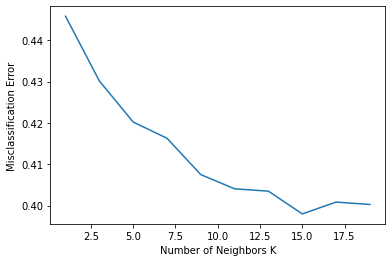

In [137]:
# plot misclassification error vs k 
plt.plot(neighbors, cv_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

### Build the final model with the optimal value of k

In [138]:
clf = KNeighborsClassifier(n_neighbors = optimal_k)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

### Make the predictions on the test set

In [139]:
y_pred = clf.predict(X_test)

### Calculate test accuracy

In [140]:
acc = accuracy_score(y_test, y_pred) * 100
acc

61.81666666666666

### Check the confusion matrix

In [141]:
confusion_matrix(y_test, y_pred)

array([[2262, 1009],
       [1282, 1447]])

### Predict Probabilities

In [142]:
# Select a random test point
i = np.random.randint(1,3000)
y_pred = clf.predict(X_test[i])[0]
y_proba = clf.predict_proba(X_test[i])[0]
print("Actual class:",y_test.iloc[i])
print("Predicted class class:",y_pred)
print("Predicted probabilities",y_proba)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.95241472 -0.17091893  0.06649352 -0.25856636 -1.05020195 -0.69460897
  0.46048325 -0.55508296  0.58903384 -0.26124027  0.12795271  0.69307806
  1.25912741 -0.93422817 -0.51177029 -0.6443625  -0.60527825 -0.89257323
 -0.45461102 -0.027901   -0.21312645  0.28195029  0.60996452  1.03341726
 -0.40934603 -0.33610004 -0.00774905 -1.05631321  1.21328121  0.48773006
  1.16911002  0.18422703  0.37041882  0.82562966  0.19231865 -0.35013024
  0.77639632 -0.96686764 -0.3680513  -0.5923377  -0.77623972  0.96599612
 -0.15395945  0.18713068 -0.08981034  0.10932837  0.40358197 -0.82869781
 -0.57010313 -0.06260093].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Sort by Time

In [263]:
final = final[['Score', 'Time', 'CleanedText']]
final.sort_values('Time', inplace = True)
final.head(10)

,Score,Time,CleanedText
117879,1,939340800,witti littl book make son laugh loud recit car...
117856,1,940809600,rememb see show air televis year ago child sis...
298565,1,944092800,beetlejuic well written movi everyth excel act...
169198,1,944438400,twist rumplestiskin captur film star michael k...
298564,1,946857600,beetlejuic excel funni movi keaton hilari wack...
169259,1,947376000,one movi movi collect fill comedi action whate...
169184,0,948240000,alway enjoy movi funni entertain hesit pick cl...
63292,1,948672000,bought apart infest fruit fli hour trap quot a...
169284,1,951523200,happen say name three time michael keaten star...
169237,1,959990400,get crazi look beatlejuic french version video...


In [264]:
final['Score'].value_counts()

1    306779
0     57078
Name: Score, dtype: int64

### Separate into X and y

In [265]:
X = final['CleanedText']
y = final['Score']

### Time based splitting

In [266]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [267]:
X_train_raw.shape, y_train.shape, X_test_raw.shape, y_test.shape

((254699,), (254699,), (109158,), (109158,))

### Put the train data and labels in one dataframe

In [268]:
df = pd.concat([pd.DataFrame(X_train_raw), pd.DataFrame(y_train)], axis=1)
df.head()

,CleanedText,Score
117879,witti littl book make son laugh loud recit car...,1
117856,rememb see show air televis year ago child sis...,1
298565,beetlejuic well written movi everyth excel act...,1
169198,twist rumplestiskin captur film star michael k...,1
298564,beetlejuic excel funni movi keaton hilari wack...,1


In [269]:
df['Score'].value_counts()

1    216688
0     38011
Name: Score, dtype: int64

### Upsample the minority class in the train dataset only

In [270]:
negative = df[df['Score'] == 0]
positive = df[df['Score'] == 1]

In [271]:
negative.shape, positive.shape

((38011, 2), (216688, 2))

### Upsample minority class

In [272]:
negative_upsampled = resample(negative, 
                                 replace=True,     # sample with replacement
                                 n_samples=216687, # to match majority class
                                 random_state=123) # reproducible results)

In [273]:
negative_upsampled.shape

(216687, 2)

In [274]:
df = pd.concat([negative_upsampled, positive], axis = 0, ignore_index = True)

### The train dataset is balanced

In [275]:
df['Score'].value_counts()

1    216688
0    216687
Name: Score, dtype: int64

### Shuffle the dataframe

In [276]:
df = shuffle(df)
df.head(10)

,CleanedText,Score
318845,realli glad find tofu amazon eat tofu daili ba...,1
284688,excel coffe recommend high rich robust tast fi...,1
428273,month old eat month get enough littl messi gre...,1
38645,usual love kashi bar tast particular bar weird...,0
293804,arriv soft chewi good tast textur last long ti...,1
335462,got daughter lab mix puppi sixti pound love fi...,1
127078,wow look forward great review got today made c...,0
383191,excel keep buy came well packag broken food md...,1
179975,bought expect freez dri appl disappoint dehydr...,0
364286,store area stop carri mint order onlin perfect...,1


In [277]:
X_train_raw = df['CleanedText']
y_train = df['Score']

### Vectorize the text using BOW

In [278]:
# Create an object of class CountVectorizer
bow = CountVectorizer()
# Call the fit_transform method on training data
X_train = bow.fit_transform(X_train_raw.values)

# Call the transform method on the test dataset
X_test = bow.transform(X_test_raw.values)

In [279]:
X_train.shape, X_test.shape

((433375, 63219), (109158, 63219))

In [280]:
start = time.time()
# creating odd list of alpha for NB
alpha = np.linspace(0.1,1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for a in alpha:
    # Create an object of the class KNeighborsClassifier
    clf = MultinomialNB(alpha = a)
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) k is the one for which error is minimum (or accuracy is maximum)
optimal_alpha = alpha[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_alpha)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal alpha is 0.1
Total time in minutes =  0.07473256985346476


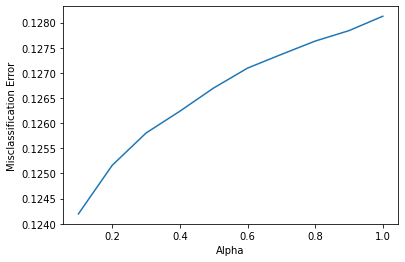

In [281]:
# plot misclassification error vs alpha
plt.plot(alpha, cv_error)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [282]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 86.30883673207644


array([[15406,  3661],
       [11284, 78807]])

### Let's try different range for alpha

In [283]:
start = time.time()
# creating odd list of alpha for NB
alpha = np.linspace(0.01,0.1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for a in alpha:
    # Create an object of the class KNeighborsClassifier
    clf = MultinomialNB(alpha = a)
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) k is the one for which error is minimum (or accuracy is maximum)
optimal_alpha = alpha[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_alpha)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal alpha is 0.01
Total time in minutes =  0.07476776838302612


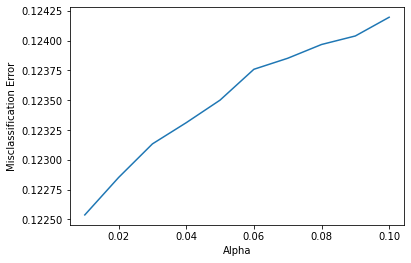

In [284]:
# plot misclassification error vs alpha
plt.plot(alpha, cv_error)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [285]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 86.1705051393393


array([[15054,  4013],
       [11083, 79008]])

### Model Interpretability

In [286]:
idx = (-clf.feature_log_prob_).argsort()[:2,:50]
print("Top 50 words in negative reviews")
for i in idx[0]:
    print(bow.get_feature_names()[i])
    
print("\n******************************************\n")
print("Top 50 words in positive reviews")
for i in idx[1]:
    print(bow.get_feature_names()[i])

Top 50 words in negative reviews
tast
like
product
one
flavor
would
tri
good
coffe
use


/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


buy
get
order
food
tea
box
even
amazon
make
bag
time
much
realli
eat
look
love
packag
review
bought
purchas
dog
chocol
first
disappoint
bad
better
want
cup
price
also
think
made
say
water
know
could
sugar
drink
ingredi
great

******************************************

Top 50 words in positive reviews
like
tast
good
flavor
love
great
use
one
product
tea
tri
coffe
make
get
food
time
would
buy
amazon
eat
realli
find
price
best
also
much
order
littl
store
well
bag
drink
dog
even
mix
chocol
cup
better
year
day
sugar
recommend
sweet
box
high
found
water
free
first
treat


### NB runs quickly, so we use the entire dataset

In [303]:
data = final[['Score', 'Time', 'CleanedText']].copy()
data.sort_values('Time', inplace = True)
data.head(10)

,Score,Time,CleanedText
117879,1,939340800,witti littl book make son laugh loud recit car...
117856,1,940809600,rememb see show air televis year ago child sis...
298565,1,944092800,beetlejuic well written movi everyth excel act...
169198,1,944438400,twist rumplestiskin captur film star michael k...
298564,1,946857600,beetlejuic excel funni movi keaton hilari wack...
169259,1,947376000,one movi movi collect fill comedi action whate...
169184,0,948240000,alway enjoy movi funni entertain hesit pick cl...
63292,1,948672000,bought apart infest fruit fli hour trap quot a...
169284,1,951523200,happen say name three time michael keaten star...
298566,1,959990400,get crazi realli imposs today find french vhs ...


### Separate X and y

In [304]:
X = data['CleanedText']
y = data['Score']

### Time based splitting

In [305]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [306]:
X_train_raw.shape, y_train.shape, X_test_raw.shape, y_test.shape

((254699,), (254699,), (109158,), (109158,))

In [315]:
# Create an object of class CountVectorizer
bow_nb = CountVectorizer()
# Call the fit_transform method on training data
X_train = bow_nb.fit_transform(X_train_raw.values)

In [316]:
X_train.shape

(254699, 63242)

In [317]:
# Call the transform method on the test dataset
X_test = bow.transform(X_test_raw.values)

In [318]:
X_test.shape

(109158, 63242)

### Column Standardization not required in Naive Bayes

In [295]:
start = time.time()
# creating odd list of alpha for NB
alpha = np.linspace(0.1,1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for a in alpha:
    # Create an object of the class KNeighborsClassifier
    clf = MultinomialNB(alpha = a)
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) k is the one for which error is minimum (or accuracy is maximum)
optimal_alpha = alpha[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_alpha)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal alpha is 1.0
Total time in minutes =  0.0412282665570577


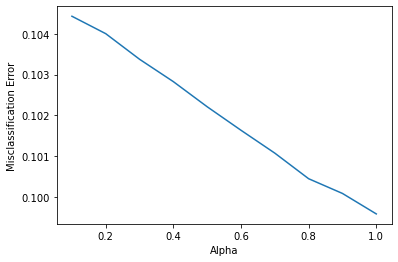

In [296]:
# plot misclassification error vs alpha
plt.plot(alpha, cv_error)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [297]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 89.43549716924092


array([[12870,  6196],
       [ 5336, 84756]])

### Let's try different range for alpha

In [298]:
start = time.time()
# creating odd list of alpha for NB
alpha = np.linspace(1,10,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for a in alpha:
    # Create an object of the class KNeighborsClassifier
    clf_nb = MultinomialNB(alpha = a)
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) k is the one for which error is minimum (or accuracy is maximum)
optimal_alpha = alpha[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_alpha)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal alpha is 1.0
Total time in minutes =  0.04221553405125936


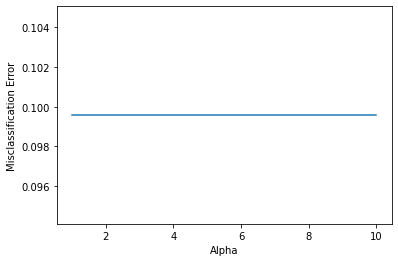

In [299]:
# plot misclassification error vs alpha
plt.plot(alpha, cv_error)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [300]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 89.43549716924092


array([[12870,  6196],
       [ 5336, 84756]])

In [311]:
tfidf = TfidfVectorizer()
# Call the fit_transform method on training data
X_train = tfidf.fit_transform(X_train_raw.values)
X_test = tfidf.transform(X_test_raw.values)

In [312]:
start = time.time()
# creating odd list of alpha for NB
alpha = np.linspace(0.1,1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for a in alpha:
    # Create an object of the class KNeighborsClassifier
    clf = MultinomialNB(alpha = a)
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) k is the one for which error is minimum (or accuracy is maximum)
optimal_alpha = alpha[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_alpha)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal alpha is 0.1
Total time in minutes =  0.04482138156890869


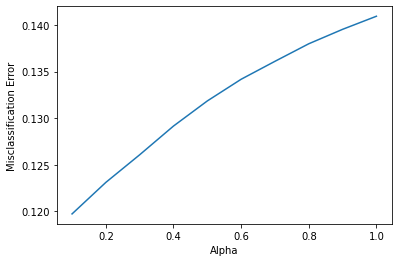

In [313]:
plt.plot(alpha, cv_error)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [314]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 86.27494091133953


array([[ 4646, 14420],
       [  562, 89530]])

### Model Interpretability

In [182]:
idx = (-clf.feature_log_prob_).argsort()[:2,:50]
print("Top 50 words in negative reviews")
for i in idx[0]:
    print(bow.get_feature_names()[i])
    
print("\n******************************************\n")
print("Top 50 words in positive reviews")
for i in idx[1]:
    print(bow.get_feature_names()[i])

Top 50 words in negative reviews
tast
like
product
one
flavor
would
tri
good

/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



coffe
use
buy
get
order
food
tea
box
even
amazon
make
bag
time
much
eat
realli
look
love
packag
review
purchas
dog
bought
first
disappoint
chocol
bad
better
want
cup
price
also
think
sugar
know
could
made
water
say
drink
ingredi
great

******************************************

Top 50 words in positive reviews
like
tast
good
flavor
love
great
use
one
product
tea
tri
coffe
make
get
food
time
would
buy
amazon
eat
realli
find
price
best
also
much
order
littl
store
well
bag
drink
dog
even
mix
chocol
cup
better
year
day
sugar
recommend
sweet
box
high
found
water
free
first
treat


### Logistic Regression

### Perform Column Standardization

In [187]:
std = StandardScaler(with_mean=False)
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

### Cross validation and Hyper Parameter tuning

In [188]:
start = time.time()
# creating list of C
C_values = np.linspace(0.1,1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for c in C_values:
    # Create an object of the class Logistic Regression with balanced class weights
    clf = LogisticRegression(C = c, class_weight = 'balanced')
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) C is the one for which error is minimum (or accuracy is maximum)
optimal_C = C_values[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_C)

end = time.time()
print("Total time in minutes = ", (end-start)/60)

/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



The optimal alpha is 0.1
Total time in minutes =  4.069187835852305


/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


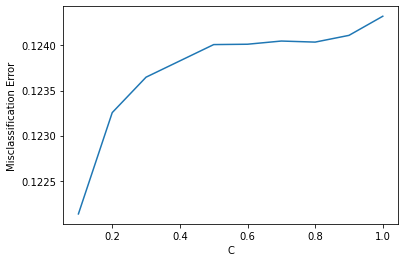

In [189]:
# plot misclassification error vs C
plt.plot(C_values, cv_error)
plt.xlabel('C')
plt.ylabel('Misclassification Error')
plt.show()

In [190]:
clf = LogisticRegression(C = optimal_C)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 89.17715604902985


/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[12153,  6914],
       [ 4900, 85191]])

### Feature Selection

In [191]:
idx = (-abs(clf.coef_)).argsort()[0,:50]
print("Top 50 features:")
for i in idx:
    print(bow.get_feature_names()[i])

Top 50 features:
great
best
love
delici
perfect
good


/Users/heet/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


excel
marmit
nice
disappoint
oomph
favorit
amaz
tasti
worst
awesom
radius
tast
yum
wonder
addict
hook
easi
terribl
smooth
return
find
beat
thank
fantast
aw
washabl
happi
http
glad
horribl
acv
yummi
muir
without
steadili
delight
even
year
glen
enjoy
hestit
biscoff
stockpil
tempera


### Read the list_of_sent created during EDA and cleaning

In [3]:
with open('../8. Amazon_New/list_of_sent_for_input_to_w2v.pkl', 'rb') as pickle_file:
    list_of_sent = pickle.load(pickle_file)

#### Training the Word2Vec model for words with min count 5¶
Reference for intuition - https://www.tensorflow.org/tutorials/word2vec

In [192]:
## size is the no of dimensions
## min_count specifies the min no of times a word needs to occur to be included in the model
## workers is the number of cores on your PC
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,vector_size=100, workers=-1)

## Function to calculate Avg Word2Vec

In [193]:
def calc_avg_w2v(list_of_sent, w2v_model):
    '''This function takes in 2 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       
       Return Value:
       sent_vectors - This is a list of sentence/review vectors constructed by averaging the word vectors
    '''
    
    ## Initialize an empty list
    sent_vectors = []
    
    ## Consider one sentence/review at a time
    for sent in list_of_sent:
        ## Initialize sentence vector to 0
        ## Note: Size of the vector must match the no. of dimensions used in word2vec model
        sent_vec = np.zeros(100)
        
        ## Initialize count of words to 0
        cnt_words = 0
        
        ## Consider the words one by one
        for word in sent:
            try:
                ## Calculate the word vector using the W2V model
                vec = w2v_model.wv[word]
                ## Add the word vector to the sentence vector (This is the numerator)
                sent_vec += vec
                ## Sum all the word counts (This is the denominator)
                cnt_words += 1
            except:
                pass
        ## Divide the numerator by the denominator to get the sentence vector
        sent_vec /= cnt_words
        ## Add the sentence vector in the final list
        sent_vectors.append(sent_vec)
    ## return the list of all the sentence vectors
    return sent_vectors

In [194]:
start = time.time()
sent_vectors = calc_avg_w2v(list_of_sent, w2v_model)
end = time.time()
print("Time taken in minutes", (end - start)/60)

/var/folders/_r/s8vczyvd2sg838smpnxck6bh0000gn/T/ipykernel_1190/556499749.py:34: RuntimeWarning: invalid value encountered in true_divide
  sent_vec /= cnt_words


Time taken in minutes 0.566904079914093


In [195]:
len(sent_vectors), len(sent_vectors[0])

(363857, 100)

### Convert the list of vectors into a pandas dataframe

In [196]:
data = pd.DataFrame(sent_vectors)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000948,0.001396,-0.000554,-0.000962,-0.000626,-0.000130,0.000117,0.002315,-0.001143,-0.002020,...,-0.000275,0.000740,0.001404,-0.000034,0.001942,0.001194,0.001753,0.000829,-0.000854,0.000495
1,-0.000775,0.000212,-0.002159,0.000256,-0.000521,-0.001870,0.000607,0.000328,-0.002344,0.002459,...,-0.000534,-0.001141,0.000234,-0.000289,0.001176,-0.000434,0.002132,0.001201,-0.002059,0.000252
2,0.000770,0.000604,0.000784,0.000393,-0.000730,-0.000386,-0.001711,-0.000100,-0.000577,-0.000758,...,-0.000031,0.000926,0.001841,-0.000253,0.001401,0.000021,0.000870,0.000908,-0.000774,0.000183
3,-0.000843,0.001646,0.001407,-0.000309,0.000729,0.001115,-0.000228,0.002174,-0.000822,0.001000,...,0.000478,-0.001037,0.000861,-0.001582,0.003073,0.000695,0.000372,-0.002951,-0.001044,-0.000389
4,-0.003714,0.002640,0.002675,-0.000799,-0.003325,0.002814,-0.001541,-0.002244,-0.002439,0.000169,...,-0.000154,0.001741,-0.001829,-0.000713,0.004165,0.003702,-0.002537,0.001050,0.002073,-0.000367


In [203]:
data = pd.concat([final['Time'], final['Score'], data], axis = 1)
data.sort_values('Time', inplace = True)
data.head()

,Time,Score,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
117879,939340800,1,0.001078,0.001142,0.000243,-0.000541,0.000264,-0.000557,0.000378,0.000013,...,0.001309,-0.000741,-0.001468,0.000132,-0.001189,-0.000585,-0.000762,0.001548,0.000783,-0.000055
117856,940809600,1,0.000959,-0.000067,-0.001198,-0.001787,-0.000363,-0.000187,-0.000192,0.001645,...,0.001089,-0.001090,-0.000354,-0.001249,-0.000361,0.001274,-0.000206,-0.000326,-0.000568,0.000932
298565,944092800,1,0.000520,-0.001400,-0.001564,0.000082,0.003201,0.000359,-0.001367,0.000998,...,-0.000197,0.001719,0.000131,0.003577,0.000822,0.001500,0.002047,-0.000071,0.003954,-0.002716
169198,944438400,1,-0.001188,-0.000968,-0.000911,-0.001479,-0.000613,0.000307,-0.000320,0.000598,...,-0.000357,0.000387,0.000412,-0.000424,0.001085,-0.002799,-0.001336,-0.001252,-0.000964,-0.001223
298564,946857600,1,-0.000434,-0.000198,0.000841,0.000521,0.000276,0.000753,0.001148,-0.000354,...,0.001327,0.001334,-0.001190,-0.000125,0.002184,0.002997,0.000760,-0.000176,0.002108,-0.000152


In [204]:
data.shape

(363857, 102)

### Due to some reasons a few rows might contain NAN values, so delete them

In [205]:
data.dropna(inplace = True)

In [206]:
data.shape

(363854, 102)

### Separate X and y

In [208]:
X = data.drop(labels=['Time', 'Score'], axis = 1)
y = data['Score']

### Time based splitting

In [209]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [210]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((254697, 100), (254697,), (109157, 100), (109157,))

### Perform Column Standardization

In [211]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [215]:
y_train.value_counts()

1    216685
0     38012
Name: Score, dtype: int64

### Cross validation and Hyper Parameter tuning

In [216]:
start = time.time()
# creating list of C
C_values = np.linspace(0.1,1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for c in C_values:
    # Create an object of the class Logistic Regression with balanced class weights
    clf = LogisticRegression(C = c, class_weight = 'balanced')
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) C is the one for which error is minimum (or accuracy is maximum)
optimal_C = C_values[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_C)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal alpha is 0.1
Total time in minutes =  0.4255964994430542


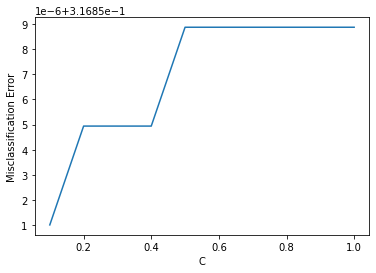

In [217]:
# plot misclassification error vs C
plt.plot(C_values, cv_error)
plt.xlabel('C')
plt.ylabel('Misclassification Error')
plt.show()

In [218]:
clf = LogisticRegression(C = optimal_C)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 83.13346830711727


array([[ 1705, 17361],
       [ 1050, 89041]])

In [219]:
## size is the no of dimensions
## min_count specifies the min no of times a word needs to occur to be included in the model
## workers is the number of cores on your PC
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,vector_size=200, workers=-1)

## Function to calculate Avg Word2Vec

In [220]:
def calc_avg_w2v(list_of_sent, w2v_model):
    '''This function takes in 2 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       
       Return Value:
       sent_vectors - This is a list of sentence/review vectors constructed by averaging the word vectors
    '''
    
    ## Initialize an empty list
    sent_vectors = []
    
    ## Consider one sentence/review at a time
    for sent in list_of_sent:
        ## Initialize sentence vector to 0
        ## Note: Size of the vector must match the no. of dimensions used in word2vec model
        sent_vec = np.zeros(200)
        
        ## Initialize count of words to 0
        cnt_words = 0
        
        ## Consider the words one by one
        for word in sent:
            try:
                ## Calculate the word vector using the W2V model
                vec = w2v_model.wv[word]
                ## Add the word vector to the sentence vector (This is the numerator)
                sent_vec += vec
                ## Sum all the word counts (This is the denominator)
                cnt_words += 1
            except:
                pass
        ## Divide the numerator by the denominator to get the sentence vector
        sent_vec /= cnt_words
        ## Add the sentence vector in the final list
        sent_vectors.append(sent_vec)
    ## return the list of all the sentence vectors
    return sent_vectors

In [221]:
start = time.time()
sent_vectors = calc_avg_w2v(list_of_sent, w2v_model)
end = time.time()
print("Time taken in minutes", (end - start)/60)

/var/folders/_r/s8vczyvd2sg838smpnxck6bh0000gn/T/ipykernel_1190/4041547280.py:34: RuntimeWarning: invalid value encountered in true_divide
  sent_vec /= cnt_words


Time taken in minutes 0.5594006458918254


In [226]:
len(sent_vectors), len(sent_vectors[0])

(363857, 200)

### Convert the list of vectors into a pandas dataframe

In [227]:
data = pd.DataFrame(sent_vectors)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.000552,0.001085,0.000585,0.001314,0.001535,0.000388,0.001185,-0.000344,-0.001742,0.000342,...,-0.000668,0.000322,-0.000145,0.000395,0.001137,-0.000639,-0.001120,-0.000087,0.000599,-0.000043
1,0.001015,0.000615,0.000054,0.000756,0.001152,0.000078,-0.000003,-0.000799,-0.000486,0.000360,...,-0.000671,-0.000270,0.000262,-0.000221,-0.000179,-0.000762,-0.002239,0.000642,0.000665,-0.000108
2,-0.000860,-0.000312,-0.000756,-0.000357,0.000267,-0.000104,-0.000609,0.001136,-0.000074,-0.000411,...,0.000406,0.001065,-0.000429,-0.000069,0.000443,-0.000164,0.000116,-0.000048,0.000266,-0.000055
3,0.000065,-0.000806,-0.001125,-0.000272,-0.000751,-0.000271,0.000037,-0.000370,-0.000052,-0.000922,...,0.000699,-0.000100,-0.000123,-0.000446,-0.000905,0.001371,-0.000663,0.000704,0.000815,-0.000236
4,-0.000012,-0.002115,-0.000439,0.000837,0.002146,0.001204,0.001088,0.001200,0.001321,0.000654,...,0.000123,0.000535,-0.000188,-0.001113,0.000930,0.001288,-0.000058,0.000232,0.002339,0.000131


In [228]:
data = pd.concat([final['Time'], final['Score'], data], axis = 1)
data.sort_values('Time', inplace = True)
data.head()

,Time,Score,0,1,2,3,4,5,6,7,...,190,191,192,193,194,195,196,197,198,199
117879,939340800,1,0.000077,-0.001097,-0.000066,-0.000255,-0.000225,-0.000309,-0.001438,-0.000216,...,-0.001070,-0.000386,0.000563,-0.000221,-0.000046,0.000393,-0.000580,-0.000079,-0.000158,-0.000672
117856,940809600,1,0.000565,-0.000546,0.000240,-0.000358,-0.001141,-0.000552,0.000068,-0.000416,...,0.000968,-0.001153,-0.000042,0.000198,0.000268,-0.000316,-0.000172,-0.000588,0.000476,0.000013
298565,944092800,1,0.000102,-0.000602,-0.001244,0.000507,0.001124,0.000607,-0.000128,0.000155,...,0.000685,0.001078,0.000060,-0.000989,-0.000127,-0.001009,-0.000620,0.000329,0.000352,-0.000462
169198,944438400,1,0.000468,0.000077,0.000522,0.000068,0.000618,0.000056,-0.000719,-0.000116,...,0.000136,0.000212,-0.000173,0.000104,0.001016,0.000352,0.000183,0.000851,0.000169,0.000056
298564,946857600,1,0.000347,-0.001451,-0.000221,-0.001082,0.000678,-0.000675,-0.000430,0.000141,...,0.000588,0.001169,0.000077,0.000005,0.000361,0.000878,-0.000187,-0.000203,0.000556,-0.001192


In [229]:
data.shape

(363857, 202)

### Due to some reasons a few rows might contain NAN values, so delete them

In [230]:
data.dropna(inplace = True)

In [231]:
data.shape

(363854, 202)

In [232]:
data['Score'].value_counts()

1    306776
0     57078
Name: Score, dtype: int64

### Separate X and y

In [233]:
X = X = data.drop(labels=['Time', 'Score'], axis = 1)
y = data['Score']

### Time based splitting

In [234]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [235]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((254697, 200), (254697,), (109157, 200), (109157,))

### Perform Column Standardization

In [236]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

### Cross validation and Hyper Parameter tuning

In [237]:
start = time.time()
# creating list of C
C_values = np.linspace(0.1,1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for c in C_values:
    # Create an object of the class Logistic Regression with balanced class weights
    clf = LogisticRegression(C = c, class_weight = 'balanced')
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) C is the one for which error is minimum (or accuracy is maximum)
optimal_C = C_values[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_C)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal alpha is 1.0
Total time in minutes =  0.6320033152898152


In [240]:
start = time.time()
# creating list of C
C_values = np.linspace(1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for c in C_values:
    # Create an object of the class Logistic Regression with balanced class weights
    clf = LogisticRegression(C = c, class_weight = 'balanced')
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) C is the one for which error is minimum (or accuracy is maximum)
optimal_C = C_values[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_C)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal alpha is 1.0
Total time in minutes =  2.8650529305140178


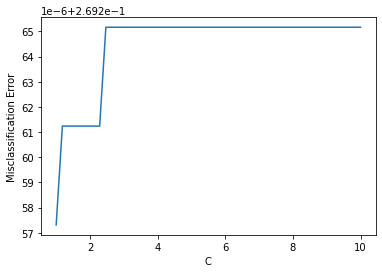

In [241]:
# plot misclassification error vs C
plt.plot(C_values, cv_error)
plt.xlabel('C')
plt.ylabel('Misclassification Error')
plt.show()

In [242]:
clf = LogisticRegression(C = optimal_C)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 84.1842483761921


array([[ 3835, 15231],
       [ 2033, 88058]])

### Save the best model.

In [319]:
#joblib.dump(tf_idf,open('Vectorizer.pkl','wb')
pickle.dump(clf_nb, open('model.pkl','wb'))
pickle.dump(bow_nb, open('vectorizer.pkl','wb'))